In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
from fastai.text import *

In [ ]:
with open('/content/en-es.tmx',mode='r') as f:
  text = f.read()
  f.close()

In [3]:
path = '/content/drive/My\ Drive/'

In [ ]:
print(text[:500])

<?xml version="1.0" encoding="UTF-8" ?>
<tmx version="1.4">
<header creationdate="Sun Mar  4 00:54:42 2018"
          srclang="en"
          adminlang="en"
          o-tmf="unknown"
          segtype="sentence"
          creationtool="Uplug"
          creationtoolversion="unknown"
          datatype="PlainText" />
  <body>
    <tu>
      <tuv xml:lang="en"><seg>RESOLUTION 55/100</seg></tuv>
      <tuv xml:lang="es"><seg>RESOLUCIÓN 55/100</seg></tuv>
    </tu>
    <tu>
      <tuv xml:lang="en"><s


In [ ]:
soup = BeautifulSoup(text,'html.parser')
row = soup.find('tu')
print(row)

x = [i for i in row.get_text().split('\n') if i!='']
print(x)

<tu>
<tuv xml:lang="en"><seg>RESOLUTION 55/100</seg></tuv>
<tuv xml:lang="es"><seg>RESOLUCIÓN 55/100</seg></tuv>
</tu>
['RESOLUTION 55/100', 'RESOLUCIÓN 55/100']


In [ ]:
text_list = []
rows = soup.find_all('tu')
for row in rows:
  x = [i for i in row.get_text().split('\n') if i!='']
  text_list.append(x)

In [ ]:
df = pd.DataFrame(text_list)

In [ ]:
df.head()

,Unnamed: 0,en,es
0,0,resolution 55/100,resolución 55/100
1,1,"adopted at the 81st plenary meeting, on 4 dece...","aprobada en la 81a. sesión plenaria, celebrada..."
2,2,"in favour: afghanistan, algeria, angola, antig...","votos a favor: afganistán, angola, antigua y b..."
3,3,"abstentions: albania, andorra, australia, aust...","abstenciones: albania, alemania, andorra, aust..."
4,4,55/100. respect for the right to universal fre...,55/100. respeto del derecho a la libertad univ...


In [ ]:
df.columns = ['en','es']

In [ ]:
df.drop(8506,axis=0,inplace=True)

In [ ]:
df.to_csv('/content/drive/My Drive/translation_data.csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/translation_data.csv')

### Pre Processing

In [ ]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['es'] = df['es'].apply(lambda x:x.lower())

In [6]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding."
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [7]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


In [8]:
class Seq2SeqTextList(TextList):
  _bunch = Seq2SeqDataBunch
  _label_cls = TextList

In [ ]:
src = Seq2SeqTextList.from_df(df,path=path,cols = 'es').split_by_rand_pct(seed=42).label_from_df(cols='en',label_cls=TextList)

In [ ]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

114.0

In [ ]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

101.0

In [ ]:
src = src.filter_by_func(lambda x,y:len(x) > 120 or len(y) > 120)

In [ ]:
xb,yb = next(iter(data.train_dl))

In [ ]:
yb.shape

torch.Size([64, 30])

In [ ]:
data = src.databunch()

In [ ]:
len(src.train + src.valid)

7786

In [ ]:
data.save('/content/drive/My Drive/data_save.pkl')

In [10]:
data

Seq2SeqDataBunch;

Train: LabelList (6242 items)
x: Seq2SeqTextList
xxbos resolución 55 / 100,xxbos aprobada en la 81a . sesión plenaria , celebrada el 4 de diciembre de 2000 , por recomendación de la comisión ( a / 55 / 602 / add.2 , párr . 94),el proyecto de resolución recomendado en el informe fue patrocinado en la comisión por los países siguientes : bolivia , cuba , el salvador , ghana y honduras . en votación registrada de 106 votos contra uno y 67 abstenciones , como sigue :,xxbos 55 / 100 . respeto del derecho a la libertad universal de xxunk e importancia vital de la reunificación de las familias,xxbos recordando las disposiciones de la declaración universal de derechos humanosresolución 217 a ( iii ) . , y el artículo 12 del pacto internacional de derechos civiles y políticosvéase resolución 2200 a ( xxi ) , anexo . ,,xxbos subrayando que , conforme se declara en el programa de acción de la conferencia internacional sobre la población y el desarrolloinforme de la conferencia 

In [9]:
data = load_data('/content/drive/My Drive')

In [ ]:
data.show_batch()

text,target
"xxbos 12 . insta a los estados a que adopten medidas especiales para proteger , en particular a las niñas afectadas por la guerra de las enfermedades de transmisión sexual , como el virus de la inmunodeficiencia humana y el síndrome de inmunodeficiencia adquirida y de la violencia que tiene su origen en el género , como la violación y el abuso sexual , la tortura , la explotación sexual","xxbos 12 . urges states to take special measures for the protection of war - affected girls and in particular to protect them from sexually transmitted diseases , such as human immunodeficiency virus / acquired immunodeficiency syndrome , and gender - based violence , including rape and sexual abuse , torture , sexual exploitation , abduction and forced labour , paying special attention to refugee and displaced girls , and to take into account the special needs of the war - affected girl child in the delivery of humanitarian assistance and disarmament , demobilization and reintegration processes ;"
"xxbos recordando el reconocimiento mutuo entre el gobierno del estado de israel y la organización de liberación de palestina , la representante del pueblo palestino , y la firma por ambas partes de la declaración de principios sobre las disposiciones relacionadas con un gobierno autónomo provisional , en washington , d.c . , el 13 de septiembre de 1993a / 48 / 486-s / 26560 , anexo . , así","xxbos recalling the mutual recognition between the government of the state of israel and the palestine liberation organization , the representative of the palestinian people , and the signing by the two parties of the declaration of principles on interim self - government arrangements in washington , d.c . , on 13 september 1993,a / 48 / 486-s / 26560 , annex . as well as the subsequent implementation agreements , including the israeli - palestinian interim agreement on the west bank and the gaza strip , signed in washington , d.c . , on 28 september 1995,a / 51 / 889-s / 1997 / 357 , annex ."
"xxbos reconociendo la función de la comisión de ciencia y tecnología para el desarrollo en la coordinación de las actividades del sistema de las naciones unidas en la esfera de la ciencia y la tecnología para el desarrollo , tomando nota de la labor que realiza la comisión en su programa de trabajo para los estados miembros , especialmente los países en desarrollo , y su labor con algunos países","xxbos recognizing the role of the commission on science and technology for development in coordinating the activities of the united nations system in the area of science and technology for development , noting the work being undertaken by the commission in its work programme for member states , especially the developing countries , and its work with some countries with economies in transition , emphasizing the importance of the activities that are to be pursued within the framework of the commission , including a broad xxunk of new global challenges in science and technology , and encouraging support for those undertakings ,"
"xxbos aprobada en la 87a . sesión plenaria , celebrada el 20 de diciembre de 2000 , sin votación , por recomendación de la comisión ( a / 55 / 579 / add.1 , párr . 11)el proyecto de resolución recomendado en el informe fue patrocinado en la comisión por los países siguientes : afganistán , armenia , azerbaiyán , belarús , bulgaria , burkina faso , ex república yugoslava","xxbos adopted at the 87th plenary meeting , on 20 december 2000 , without a vote , on the recommendation of the committee ( a / 55 / 579 / add.1 , para . 11)the draft resolution recommended in the report was sponsored in the committee by : afghanistan , armenia , azerbaijan , belarus , bulgaria , burkina faso , georgia , iran ( islamic republic of ) , kazakhstan , kyrgyzstan , lao people 's democratic republic , mongolia , paraguay , philippines , poland , republic of moldova , romania , russian federation , swaziland , tajikistan , the former yugoslav republic of macedonia

### Embedding Model

In [ ]:
# Downloading Embeddings from fastext
!pip install fasttext

     |████████████████████████████████| 71kB 2.8MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3013473 sha256=0e4a37a924dc9e7663dcf28104c35948ceeab0b4066fbe22f45c889968b818bb
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
from fasttext import FastText as ft

In [ ]:
# DON'T USE. VERY SHITTY METHOD

# Downloading Pretrained Word Embedding for both languages 
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz -P {path}

--2020-06-17 06:37:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  12.4MB/s    in 5m 49s  

2020-06-17 06:42:58 (12.3 MB/s) - ‘/content/drive/My Drive/cc.en.300.bin.gz’ saved [4503593528/4503593528]

--2020-06-17 06:43:01--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45001076

In [ ]:
import fasttext.util

In [ ]:
fasttext.util.download_model('es',if_exists='ignore')

'cc.es.300.bin'

In [ ]:
fasttext.util.download_model('en',if_exists='ignore')

'cc.en.300.bin'

In [ ]:
es_vecs = ft.load_model('cc.es.300.bin')
en_vecs = ft.load_model('cc.en.300.bin')

In [ ]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
  emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
  wgts = emb.weight.data
  vec_dic = {w: vecs.get_word_vector(w) for w in vecs.get_words()}
  miss = []
  for i,w in enumerate(itos):
    try: wgts[i] = tensor(vec_dic[w])
    except: miss.append(w)
  return emb

In [ ]:
emb_enc = create_emb(es_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [ ]:
print(emb_enc.weight.size())
print(emb_dec.weight.size())

torch.Size([5424, 300])
torch.Size([4576, 300])


In [ ]:
torch.save(emb_enc,'/content/drive/My Drive/es_emb.pth')
torch.save(emb_dec,'/content/drive/My Drive/en_emb.pth')

In [11]:
emb_enc = torch.load('/content/drive/My Drive/es_emb.pth')
emb_dec = torch.load('/content/drive/My Drive/en_emb.pth')

## Model Creation

### Seq2seq with RNN

In [12]:
class Seq2SeqRNN(nn.Module):
  def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
    super().__init__()
    self.nl, self.nh, self.out_sl = nl, nh, out_sl
    self.bos_idx, self.pad_idx = bos_idx, pad_idx
    self.emb_sz_enc = emb_enc.embedding_dim
    self.emb_sz_dec = emb_dec.embedding_dim
    self.voc_sz_dec = emb_dec.num_embeddings
    
    self.emb_enc = emb_enc
    self.emb_enc_drop = nn.Dropout(0.15)
    self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, batch_first=True)
    self.out_enc = nn.Linear(nh, self.emb_sz_dec, bias=False)

    self.emb_dec = emb_dec
    self.gru_dec = nn.GRU(self.emb_sz_dec, self.emb_sz_dec, num_layers=nl, dropout=0.1, batch_first=True)
    self.out_drop = nn.Dropout(0.35)
    self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
    self.out.weight.data = self.emb_dec.weight.data

  def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

  def encoder(self, bs, inp):
    h = self.initHidden(bs)
    emb = self.emb_enc_drop(self.emb_enc(inp))
    _, h = self.gru_enc(emb, h)
    h = self.out_enc(h)
    return h

  def decoder(self, dec_inp, h):
    emb = self.emb_dec(dec_inp).unsqueeze(1)
    outp, h = self.gru_dec(emb, h)
    outp = self.out(self.out_drop(outp[:,0]))
    return h, outp

  def forward(self, inp):
    bs, sl = inp.size()
    h = self.encoder(bs, inp)
    dec_inp = inp.new_zeros(bs).long() + self.bos_idx

    res = []
    for i in range(self.out_sl):
      h, outp = self.decoder(dec_inp, h)
      dec_inp = outp.max(1)[1]
      res.append(outp)
      if (dec_inp == self.pad_idx).all(): break
    return torch.stack(res, dim=1)

In [13]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 120)

In [14]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(5424, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(4576, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=4576, bias=True)
)

In [16]:
xb,yb=next(iter(data.valid_dl))

In [17]:
h = rnn.encoder(64, xb.cpu())

In [18]:
h.size()

torch.Size([2, 64, 300])

In [19]:
def seq2seqloss(out, targ, pad_idx=1):
  bs, targ_len = targ.size()
  _ ,out_len,vs = out.size()
  if targ_len > out_len: out = F.pad(out, (0,0,0,targ_len-out_len,0,0), value=pad_idx)
  if out_len > targ_len : targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
  return CrossEntropyFlat()(out,targ)

#### Training

In [20]:
learn = Learner(data, rnn, loss_func=seq2seqloss)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


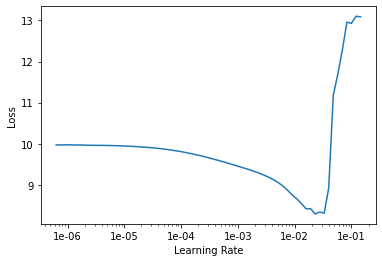

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(4,1e-3)

epoch,train_loss,valid_loss,time
0,6.345390,7.230646,00:18
1,6.464007,7.193672,00:09
2,6.645487,6.934751,00:06
3,6.492787,6.936026,00:07


**Since loss is not useful to interpret what's happening we come up with an accuracy function**

In [33]:
def seq2seq_acc(out, targ, pad_idx=1):
  bs,targ_len = targ.size()
  _,out_len,vs = out.size()
  if targ_len > out_len: out = F.pad(out, (0,0,0,targ_len-out_len,0,0), value=pad_idx)
  if out_len > targ_len : targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
  out = out.argmax(2)
  return (out==targ).float().mean()

**Using Bleu Metric** 
>We invent our own since NLTK takes 5 hours to calculate on my model

In [24]:
class NGram():
  def __init__(self, ngram, max_n=5000):
    self.ngram = ngram
    self.max_n = max_n

  def __eq__(self,other):
    if len(self.ngram) != len(other.ngram): return False
    return np.all(np.array(self.ngram) == np.array(other.ngram))

  def __hash__(self):
    return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [25]:
def get_grams(x, n, max_n=5000):
  return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [37]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

>We create a callback for calculating the Bleu score on a corpus which is basically:

>score = penalty * ((a * b * c * d)  ** 0.25)

In [29]:
class CorpusBleu(Callback):
  def __init__(self, vocab_sz):
    self.vocab_sz = vocab_sz
    self.name = 'bleu'
  
  def on_epoch_begin(self, **kwargs):
    self.pred_len, self.targ_len, self.corrects, self.counts = 0, 0, [0]*4, [0]*4
  
  def on_batch_end(self, last_output, last_target, **kwargs):
    last_output = last_output.argmax(dim=-1)
    for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
      self.pred_len += len(pred)
      self.targ_len += len(targ)
      for i in range(4):     # Get max quad grams (or whatever they call ngrams of length 4)
        c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
        self.corrects[i] += c
        self.counts[i] += t

  def on_epoch_end(self, last_metrics, **kwargs):
    precs = [c/t for c,t in zip(self.corrects, self.counts)]
    len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
    bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
    return add_metrics(last_metrics, bleu)

**Training with metrics now**

In [44]:
learn = Learner(data, rnn, loss_func=seq2seqloss, metrics=[seq2seq_acc, CorpusBleu(len(data.y.vocab.itos))])

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


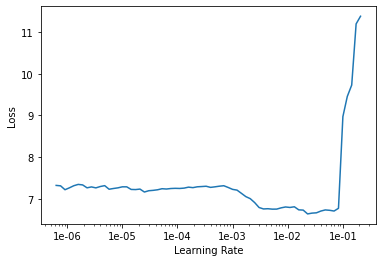

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,5.955884,3.677555,0.313295,0.066538,00:19
1,4.915508,3.352515,0.408228,0.066251,00:21
2,4.357631,3.619857,0.357838,0.054041,00:22
3,4.222044,3.472065,0.399986,0.061025,00:22


> Checking predictions with greedy method here

In [99]:
def get_predictions(learn, ds_type=DatasetType.Valid):
  learn.model.eval()
  inputs, targets, outputs = [],[],[]
  with torch.no_grad():
    for xb,yb in progress_bar(learn.dl(ds_type)):
      out = learn.model(xb)
      for x,y,z in zip(xb,yb,out):
        x, y, z = x.cpu(), y.cpu(), z.cpu()
        inputs.append(learn.data.train_ds.x.vocab.textify(x))
        targets.append(learn.data.train_ds.y.vocab.textify(y))
        outputs.append(learn.data.train_ds.y.vocab.textify(z.argmax(1)))
  return inputs, outputs, targets

In [95]:
inputs, outputs, targets = get_predictions(learn)

In [96]:
inputs[0]

'xxbos 4 . exhorta a todos los gobiernos y a las partes en situaciones complejas de emergencia humanitaria , en particular en los conflictos armados y en las situaciones posteriores a éstos , en los países donde xxunk actividades el personal de asistencia humanitaria a que , de conformidad con las disposiciones pertinentes del derecho internacional y de la legislación nacional , cooperen plenamente con las naciones unidas y otros organismos y organizaciones humanitarios y garanticen el libre acceso , en condiciones de seguridad , del personal de asistencia humanitaria para que éste pueda desempeñar con eficacia su tarea de ayudar a la población civil afectada , incluidos los refugiados y los desplazados en el interior de su país ;'

In [97]:
targets[0]

'xxbos 4 . calls upon all governments and parties in complex humanitarian emergencies , in particular in armed conflicts and in post - conflict situations , in countries in which humanitarian personnel are operating , in conformity with the relevant provisions of international law and national laws , to cooperate fully with the united nations and other humanitarian agencies and organizations and to ensure the safe and unhindered access of humanitarian personnel in order to allow them to xxunk efficiently their task of assisting the affected civilian population , including refugees and internally displaced persons ; xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad'

In [100]:
outputs[0]

'xxbos 1 . requests the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the'

As we see, greedy method sucks and so does our model accuracy. (atleast it predicts the '.' correctly)

### *+Teacher Forcing*

To solve this ambuguity we'll be using Teacher Forcing, which feeds the real outputs to the decoder in the inital epochs instead of the predictions

In [101]:
class TeacherForcing(LearnerCallback):
  def __init__(self, learn, end_epoch):
    super().__init__(learn)
    self.end_epoch = end_epoch

  def on_batch_begin(self, last_input, last_target, train, **kwargs):
    if train: return {'last_input': [last_input, last_target]}

  def on_epoch_begin(self, epoch, **kwargs):
    self.learn.model.pr_force = 1 - epoch/self.end_epoch

In [113]:
class Seq2SeqRNN_tf(nn.Module):
  def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
    super().__init__()
    self.nl, self.nh, self.out_sl = nl, nh, out_sl
    self.bos_idx, self.pad_idx = bos_idx, pad_idx
    self.emb_sz_enc = emb_enc.embedding_dim
    self.emb_sz_dec = emb_dec.embedding_dim
    self.voc_sz_dec = emb_dec.num_embeddings
    
    self.emb_enc = emb_enc
    self.emb_enc_drop = nn.Dropout(0.15)
    self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, batch_first=True)
    self.out_enc = nn.Linear(nh, self.emb_sz_dec, bias=False)

    self.emb_dec = emb_dec
    self.gru_dec = nn.GRU(self.emb_sz_dec, self.emb_sz_dec, num_layers=nl, dropout=0.1, batch_first=True)
    self.out_drop = nn.Dropout(0.35)
    self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
    self.out.weight.data = self.emb_dec.weight.data

  def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

  def encoder(self, bs, inp):
    h = self.initHidden(bs)
    emb = self.emb_enc_drop(self.emb_enc(inp))
    _, h = self.gru_enc(emb, h)
    h = self.out_enc(h)
    return h

  def decoder(self, dec_inp, h):
    emb = self.emb_dec(dec_inp).unsqueeze(1)
    outp, h = self.gru_dec(emb, h)
    outp = self.out(self.out_drop(outp[:,0]))
    return h, outp

  def forward(self, inp, targ=None):
    bs, sl = inp.size()
    h = self.encoder(bs, inp)
    dec_inp = inp.new_zeros(bs).long() + self.bos_idx
    res = []
    for i in range(self.out_sl):
      h, outp = self.decoder(dec_inp, h)
      res.append(outp)
      dec_inp = outp.max(1)[1]
      if (dec_inp == self.pad_idx).all(): break
      if (targ is not None) and (random.random()<self.pr_force):
        if i>=targ.shape[1]:continue
        dec_inp = targ[:,i]

    return torch.stack(res, dim=1)

In [114]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 120)

tf_learn = Learner(data, rnn_tf, loss_func=seq2seqloss, metrics=[seq2seq_acc, CorpusBleu(len(data.y.vocab.itos))],
                   callback_fns=partial(TeacherForcing, end_epoch = 3))

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


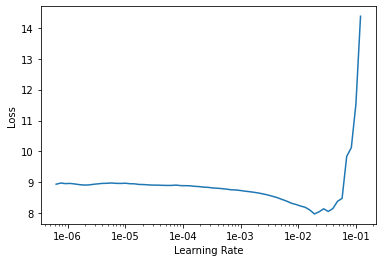

In [115]:
tf_learn.lr_find()
tf_learn.recorder.plot()

In [116]:
tf_learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,7.396241,6.278553,0.037397,0.000000,00:29
1,3.945722,3.903654,0.161615,0.030844,00:26
2,3.608405,4.028789,0.088401,0.016254,00:24
3,6.086068,5.441931,0.181560,0.083698,00:12
4,6.121037,6.266303,0.130876,0.068657,00:11
5,5.735729,5.479828,0.197839,0.102935,00:13


epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


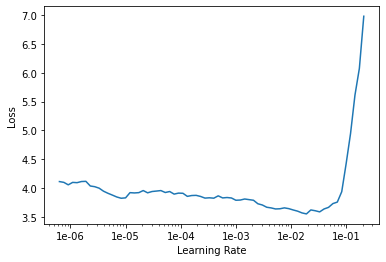

In [125]:
tf_learn.lr_find()
tf_learn.recorder.plot()

In [126]:
tf_learn.fit_one_cycle(6, 2e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.042377,5.048729,0.252928,0.065551,00:23
1,2.909665,5.889709,0.202580,0.171912,00:17
2,3.409511,3.988669,0.347046,0.173566,00:18
3,5.091806,5.733521,0.171049,0.160508,00:13
4,4.344944,4.687820,0.278746,0.206522,00:15
5,4.030360,4.536533,0.299838,0.210434,00:16


In [127]:
inputs, outputs, targets = get_predictions(tf_learn)

In [128]:
inputs[0]

'xxbos 4 . exhorta a todos los gobiernos y a las partes en situaciones complejas de emergencia humanitaria , en particular en los conflictos armados y en las situaciones posteriores a éstos , en los países donde xxunk actividades el personal de asistencia humanitaria a que , de conformidad con las disposiciones pertinentes del derecho internacional y de la legislación nacional , cooperen plenamente con las naciones unidas y otros organismos y organizaciones humanitarios y garanticen el libre acceso , en condiciones de seguridad , del personal de asistencia humanitaria para que éste pueda desempeñar con eficacia su tarea de ayudar a la población civil afectada , incluidos los refugiados y los desplazados en el interior de su país ;'

In [129]:
targets[0]

'xxbos 4 . calls upon all governments and parties in complex humanitarian emergencies , in particular in armed conflicts and in post - conflict situations , in countries in which humanitarian personnel are operating , in conformity with the relevant provisions of international law and national laws , to cooperate fully with the united nations and other humanitarian agencies and organizations and to ensure the safe and unhindered access of humanitarian personnel in order to allow them to xxunk efficiently their task of assisting the affected civilian population , including refugees and internally displaced persons ; xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad'

In [130]:
outputs[0]

'xxbos 4 . calls upon states states to , and and and , and , and , and and , and , and and , and , and and , and , and and , and and , and and , the the the the and and and the the the the the the the the and and and the the the the the the the the the the the the the the the the the the the xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad'

A bit better :P